In [1]:
from ROOT import gSystem, TChain, TLorentzVector, TFile, TTree, TRandom2, gInterpreter
from itertools import combinations, permutations
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import math
import itertools
import matplotlib.cm as cm
import subprocess
import os


Welcome to JupyROOT 6.19/01


In [2]:
gInterpreter.AddIncludePath("/home/lihuang/tools/MG5_aMC_v2_6_6/Delphes/")
gInterpreter.AddIncludePath("/home/lihuang/tools/MG5_aMC_v2_6_6/Delphes/external/")
gInterpreter.Declare('#include "/home/lihuang/tools/MG5_aMC_v2_6_6/Delphes/classes/DelphesClasses.h"')

gInterpreter.Declare('#include "/home/lihuang/tools/MG5_aMC_v2_6_6/Delphes/external/ExRootAnalysis/ExRootAnalysisLinkDef.h"')

gSystem.Load("/home/lihuang/tools/MG5_aMC_v2_6_6/Delphes/libDelphes.so")


gInterpreter.Declare('#include "/home/lihuang/tools/MG5_aMC_v2_6_6/ExRootAnalysis/ExRootAnalysis/ExRootClasses.h"')
gSystem.Load('/home/lihuang/tools/root6/lib/libHist.so')
gSystem.Load('/home/lihuang/tools/root6/lib/libGraf.so')
gSystem.Load('/home/lihuang/tools/root6/lib/libGpad.so')

gSystem.Load('/home/lihuang/tools/MG5_aMC_v2_6_6/ExRootAnalysis/libExRootAnalysis.so')


0

Warning in <TClassTable::Add>: class ExRootTreeReader already in TClassTable
Warning in <TClassTable::Add>: class ExRootTreeWriter already in TClassTable
Warning in <TClassTable::Add>: class ExRootTreeBranch already in TClassTable
Warning in <TClassTable::Add>: class ExRootResult already in TClassTable
Warning in <TClassTable::Add>: class ExRootClassifier already in TClassTable
Warning in <TClassTable::Add>: class ExRootFilter already in TClassTable


In [3]:
chain1 = TChain("LHEF")
chain1.Add('/mnt/10Ti/lihuang/combinatory/data/mg5_data/pp2tt/Events/run_01_0/unweighted_events.root')
print ("The event number is", chain1.GetEntries())


The event number is 1000000


In [4]:
def SolveForNuMom(l, b, mtop, nueta):
    nu1, nu2 = TLorentzVector(), TLorentzVector()
    Wmass = 80.
    Wmass2 = Wmass*Wmass
    bmass = 0.0
    coshnueta = math.cosh(nueta)
    sinhnueta = math.sinh(nueta)
    
    Elprime = l.E()*coshnueta-l.Pz()*sinhnueta
    Ebprime = b.E()*coshnueta-b.Pz()*sinhnueta
    
    if(b.Px()*Elprime-l.Px()*Ebprime!=0):

        A = (l.Py()*Ebprime-b.Py()*Elprime)/(b.Px()*Elprime-l.Px()*Ebprime)
        B = (Elprime*(mtop*mtop-Wmass2-bmass*bmass-2.*(l*b))-Ebprime*Wmass2)/(2.*(l.Px()*Ebprime-b.Px()*Elprime))

        par1 = (l.Px()*A+l.Py())/Elprime
        C = A*A+1.-par1*par1
        par2 = (Wmass2/2.+l.Px()*B)/Elprime
        D = 2.*(A*B-par2*par1)
        F = B*B-par2*par2
        det = D*D-4.*C*F

        if (det == 0.):
            py =-D/(2.*C)
            px = A*py+B
            pT2 = px*px+py*py
            pz = math.sqrt(pT2)*sinhnueta
            nu1.SetPxPyPzE(px, py, pz, math.sqrt(pT2+pz*pz))

        if (det > 0.):
            tmp = math.sqrt(det)/(2.*C)
            py1 =-D/(2.*C)+tmp
            py2 =-D/(2.*C)-tmp
            px1 = A*py1+B
            px2 = A*py2+B
            pT2_1 = px1*px1+py1*py1
            pT2_2 = px2*px2+py2*py2
            pz1 = math.sqrt(pT2_1)*sinhnueta
            pz2 = math.sqrt(pT2_2)*sinhnueta
            E1 = math.sqrt(pT2_1+pz1*pz1)
            E2 = math.sqrt(pT2_2+pz2*pz2)

            nu1.SetPxPyPzE(px1, py1, pz1, E1)
            nu2.SetPxPyPzE(px2, py2, pz2, E2)

    return nu1, nu2
    #return det

def neutrino_weight(nu1, nu2, met):
    dx = met.Px()-nu1.Px()-nu2.Px()
    dy = met.Py()-nu1.Py()-nu2.Py()
    #sigmaX, sigmaY = math.sqrt(met.E()), math.sqrt(met.E()) ###!!!
    sigmaX, sigmaY = math.sqrt(math.sqrt(met.Px()**2+met.Py()**2)), math.sqrt(math.sqrt(met.Px()**2+met.Py()**2)) ###!!!

    weight = math.exp(-dx**2/(2.*sigmaX**2)-dy**2/(2.*sigmaY**2))
    return weight

def GaussNuEta(eta):
    eta_sigma = 172 ####
    weight = 1/(eta_sigma*math.sqrt(2*math.pi))*math.exp(eta**2)/(2*eta_sigma**2)
    return weight


def jet_weight(E_jet, E_parton, p1, p2, p3, p4, p5):
    delta = E_jet-E_parton
    weight = 1/(math.sqrt(2*math.pi)*(p2+p3*p5))*(math.exp(-(delta-p1)**2/(2*p2**2))+p3*math.exp(-(delta-p4)**2/(2*p5**2)))
    return weight

def smear(particle, PID):
    if(PID=="quark"):
        E, px, py, pz = particle.E(), particle.Px(), particle.Py(), particle.Pz()
        sigma = ((5.3/E)**2+(0.74/E**0.5)**2+0.05)**0.5
        new_E = np.random.normal(E, E*sigma)
        ratio = new_E/E
        new_px, new_py, new_pz = px*ratio, py*ratio, pz*ratio
        new_particle = TLorentzVector()
        new_particle.SetPxPyPzE(new_px, new_py, new_pz, new_E)
        if(new_E<=0):
            new_particle.SetPxPyPzE(0, 0, 0, 0)
        
    if(PID=="electron"):
        E, px, py, pz = particle.E(), particle.Px(), particle.Py(), particle.Pz()
        sigma = 0.3/E+0.1/E**0.5+0.01
        new_E = np.random.normal(E, E*sigma)
        ratio = new_E/E
        new_px, new_py, new_pz = px*ratio, py*ratio, pz*ratio
        new_particle = TLorentzVector()
        new_particle.SetPxPyPzE(new_px, new_py, new_pz, new_E)
        if(new_E<=0):
            new_particle.SetPxPyPzE(0, 0, 0, 0)

    if(PID=="muon"):
        E, px, py, pz = particle.E(), particle.Px(), particle.Py(), particle.Pz()
        sigma_ID = (0.023035**2+(0.000347*E)**2)**0.5
        sigma_MS = ((0.12/E)**0.5+0.03278**2+(0.00014*E)**2)**0.5
        sigma = sigma_ID*sigma_MS/(sigma_ID**2+sigma_MS**2)**0.5
        new_E = np.random.normal(E, E*sigma)
        ratio = new_E/E
        new_px, new_py, new_pz = px*ratio, py*ratio, pz*ratio
        new_particle = TLorentzVector()
        new_particle.SetPxPyPzE(new_px, new_py, new_pz, new_E)
        if(new_E<=0):
            new_particle.SetPxPyPzE(0, 0, 0, 0)

    return new_particle, sigma



def calculate_pi(eta, E_parton):
    if abs(eta)<0.5:
        a1, b1 = 5.87, -1.35*10**(-1)
        a2, b2 = 2.18, 1.59*10**(-1)
        a3, b3 = 0, 8.09*10**(-5)
        a4, b4 = 4.32*10**1, 1.74*10**(-1)
        a5, b5 = 1.92*10**1, -1.26*10**(-1)
        
    elif abs(eta)<1.0:
        a1, b1 = 7.46, -1.50*10**(-1)
        a2, b2 = 2.57, 1.62*10**(-1)
        a3, b3 = 0, 1.56*10**(-4)
        a4, b4 = 3.03*10**1, 1.58*10**(-1)
        a5, b5 = 2.00*10**1, -5.39*10**(-2)

    elif abs(eta)<1.5:
        a1, b1 = 1.01, -1.68*10**(-1)
        a2, b2 = 3.67, 1.57*10**(-1)
        a3, b3 = 0, 1.85*10**(-4)
        a4, b4 = 3.72*10**1, 1.82*10**(-1)
        a5, b5 = 1.95*10**1, -6.95*10**(-2)
        
    else:
        a1, b1 = 2.31, -3.12*10**(-1)
        a2, b2 = 1.09, 8.91*10**(-2)
        a3, b3 = 0, 2.18*10**(-3)
        a4, b4 = 2.67*10**1, -5.67*10**(-2)
        a5, b5 = 2.24*10**1, 1.24*10**(-2)
        
    p1 = a1+E_parton*b1
    p2 = a2+E_parton*b2
    p3 = a3+E_parton*b3
    p4 = a4+E_parton*b4
    p5 = a5+E_parton*b5


    return p1, p2, p3, p4, p5
        
    
def calculateWeight(b1_smear, b2_smear, l1, l2):
    #C
    weight_ = []
    weight = 0
    weight1 = 0
    weight2_b1, weight2_b2 = 0, 0
    
    #W
    weight_W_ = []
    weight_W = 0
    weight1_W = 0
    weight2_W_b1, weight2_W_b2 = 0, 0

    
    #met = l1+l2+new_b1+new_b2
    #met = -met

    jet1_, jet2_ = [], []
    temp_jet1, temp_jet2 = 0, 0
    temp_jet1_W, temp_jet2_W = 0, 0
    temp_weight_C, temp_weight_W = 0, 0
    for b1E in np.linspace(1, b1_smear.E()*2, 100):
        p1, p2, p3, p4, p5 = calculate_pi(b1_smear.Eta(), b1E)
        weight2_b1 = jet_weight(b1_smear.E(), b1E, p1, p2, p3, p4, p5)
        jet1_.append([b1E, weight2_b1])
        
    for b2E in np.linspace(1, b2_smear.E()*2, 100):
        p1, p2, p3, p4, p5 = calculate_pi(b2_smear.Eta(), b2E)
        weight2_b2 = jet_weight(b2_smear.E(), b2E, p1, p2, p3, p4, p5)
        jet2_.append([b2E, weight2_b2])
        
    for idx in range(len(jet1_)):
        b1E, b2E = jet1_[idx][0], jet2_[idx][0]
        weight2_b1, weight2_b2 = jet1_[idx][1], jet2_[idx][1]
        new_b1, new_b2 = TLorentzVector(), TLorentzVector()
        new_b1.SetPxPyPzE(b1_smear.Px()*b1E/b1_smear.E(), b1_smear.Py()*b1E/b1_smear.E(), b1_smear.Pz()*b1E/b1_smear.E(), b1_smear.E()*b1E/b1_smear.E())
        new_b2.SetPxPyPzE(b2_smear.Px()*b2E/b2_smear.E(), b2_smear.Py()*b2E/b2_smear.E(), b2_smear.Pz()*b2E/b2_smear.E(), b2_smear.E()*b2E/b2_smear.E())
    
        #p1, p2, p3, p4, p5 = calculate_pi(new_b1.Eta(), b1.E())
        #weight2_b1 = jet_weight(new_b1.E(), b1.E(), p1, p2, p3, p4, p5)
        #p1, p2, p3, p4, p5 = calculate_pi(new_b2.Eta(), b2.E())
        #weight2_b2 = jet_weight(new_b2.E(), b2.E(), p1, p2, p3, p4, p5)
        
        met = l1+l2+new_b1+new_b2
        met = -met


        one_weight_ = []
        for eta in np.linspace(-5, 5, 100):
            nu1, nu1_V2 = SolveForNuMom(l1, new_b1, 172., eta)
            for eta2 in np.linspace(-5, 5, 100):
                nu2, nu2_V2 = SolveForNuMom(l2, new_b2, 172., eta2)
                if((nu1.Pt()+nu1_V2.Pt())>0 and (nu2.Pt()+nu2_V2.Pt())>0):
                    weight = neutrino_weight(nu1, nu2, met)
                    weight1 = GaussNuEta(eta)*GaussNuEta(eta2)*((new_b1+l1).M()+(new_b2+l2).M())**(-2)
                    if(nu1_V2.Pt()==0 and nu2_V2.Pt()>0):
                        weight += neutrino_weight(nu1, nu2_V2, met)
                    if(nu1_V2.Pt()>0 and nu2_V2.Pt()==0):
                        weight += neutrino_weight(nu1_V2, nu2, met)
                    if(nu1_V2.Pt()>0 and nu2_V2.Pt()>0):
                        weight += neutrino_weight(nu1, nu2_V2, met)
                        weight += neutrino_weight(nu1_V2, nu2, met)
                        weight += neutrino_weight(nu1_V2, nu2_V2, met)

                    weight_.append(weight*weight1*weight2_b1*weight2_b2)
                    one_weight_.append(weight*weight1*weight2_b1*weight2_b2)
                    #weight_.append(weight*weight1)
                    if(max(one_weight_)>temp_weight_C):
                        temp_weight_C = max(one_weight_)
                        temp_jet1, temp_jet2 = b1E, b2E
                    
        #W
        p1, p2, p3, p4, p5 = calculate_pi(new_b1.Eta(), b2.E())
        weight2_W_b1 = jet_weight(new_b1.E(), b2.E(), p1, p2, p3, p4, p5)
        p1, p2, p3, p4, p5 = calculate_pi(new_b2.Eta(), b1.E())
        weight2_W_b2 = jet_weight(new_b2.E(), b1.E(), p1, p2, p3, p4, p5)

        one_weight_W_ = []
        for eta in np.linspace(-5, 5, 100):
            nu1, nu1_V2 = SolveForNuMom(l1, new_b2, 172., eta)
            for eta2 in np.linspace(-5, 5, 100):
                nu2, nu2_V2 = SolveForNuMom(l2, new_b1, 172., eta2)
                if((nu1.Pt()+nu1_V2.Pt())>0 and (nu2.Pt()+nu2_V2.Pt())>0):
                    weight_W = neutrino_weight(nu1, nu2, met)
                    weight1_W = GaussNuEta(eta)*GaussNuEta(eta2)*((new_b2+l1).M()+(new_b1+l2).M())**(-2)
                    if(nu1_V2.Pt()==0 and nu2_V2.Pt()>0):
                        weight_W += neutrino_weight(nu1, nu2_V2, met)
                    if(nu1_V2.Pt()>0 and nu2_V2.Pt()==0):
                        weight_W += neutrino_weight(nu1_V2, nu2, met)
                    if(nu1_V2.Pt()>0 and nu2_V2.Pt()>0):
                        weight_W += neutrino_weight(nu1, nu2_V2, met)
                        weight_W += neutrino_weight(nu1_V2, nu2, met)
                        weight_W += neutrino_weight(nu1_V2, nu2_V2, met)

                    weight_W_.append(weight_W*weight1_W*weight2_W_b1*weight2_W_b2)
                    one_weight_W_.append(weight_W*weight1_W*weight2_W_b1*weight2_W_b2)
                    #weight_W_.append(weight_W*weight1_W)
                    if(max(one_weight_W_)>temp_weight_W):
                        temp_weight_W = max(one_weight_W_)
                        temp_jet1_W, temp_jet2_W = b1E, b2E

    if(len(weight_)==0):
        weight_.append(-1e9)

    if(len(weight_W_)==0):
        weight_W_.append(-1e9)
    
    #print (max(weight_), max(weight_W_))
    #return [max(weight_), max(weight_W_)] ###no plot
    return max(weight_), max(weight_W_), jet1_, jet2_, temp_jet1, temp_jet2, temp_jet1_W, temp_jet2_W  #plot 1


def loopCalculateWeight(events_):
    result = []
    for event in events_:
        #b1, b2, new_b1, new_b2, l1, l2 = event[0], event[1], event[2], event[3], event[4], event[5]
        b1, b2, b1_smear, b2_smear, l1, l2 = event[0], event[1], event[2], event[3], event[4], event[5]
        #weight = calculateWeight(b1, b2, new_b1, new_b2, l1, l2)
        weight = calculateWeight(b1_smear, b2_smear, l1, l2)
        result.append(weight)
    return result

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


In [5]:
%%time
start_time = time.time()
event_ = []
print ("START")
for count, event in enumerate(chain1):
    if((count+1)%1e2==0):
        break
        print ("Event: %d, time: %.2f" %(count+1, (time.time()-start_time)/3600.))
    if(count==5e2): break
    b1, b2, l1, l2 = TLorentzVector(), TLorentzVector(), TLorentzVector(), TLorentzVector()
    for particle in event.Particle:        
        if(particle.PID==5 and particle.Status==1):
            b1.SetPxPyPzE(particle.Px, particle.Py, particle.Pz, particle.E)
            b1_smear, _ = smear(b1, PID="quark")
        if(particle.PID==-5 and particle.Status==1):
            b2.SetPxPyPzE(particle.Px, particle.Py, particle.Pz, particle.E)
            b2_smear, _ = smear(b2, PID="quark")
        if((particle.PID==-11 or particle.PID==-13) and particle.Status==1):
            l1.SetPxPyPzE(particle.Px, particle.Py, particle.Pz, particle.E)
        if((particle.PID==11 or particle.PID==13) and particle.Status==1):
            l2.SetPxPyPzE(particle.Px, particle.Py, particle.Pz, particle.E)
    
    event_.append([b1, b2, b1_smear, b2_smear, l1, l2])
    
    w_C, w_W, jet1_, jet2_, temp_jet1, temp_jet2, temp_jet1_W, temp_jet2_W = calculateWeight(b1_smear, b2_smear, l1, l2)
    
jet1_, jet2_ = np.array(jet1_), np.array(jet2_)


START
CPU times: user 30min 48s, sys: 8min 7s, total: 38min 55s
Wall time: 38min 17s


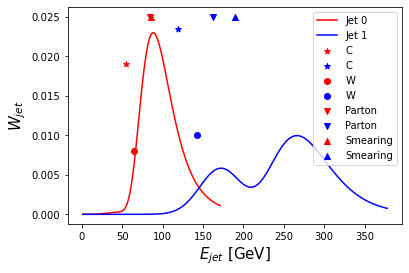

In [6]:
plt.plot(jet1_[:, 0], jet1_[:, 1], label='Jet 0', color='r')
plt.plot(jet2_[:, 0], jet2_[:, 1], label='Jet 1', color='b')

plt.scatter(temp_jet1, 0.019, color='r', marker='*', label="C")
plt.scatter(temp_jet2, 0.0235, color='b', marker='*', label="C")

plt.scatter(temp_jet1_W, 0.008, color='r', marker='o', label="W")
plt.scatter(temp_jet2_W, 0.01, color='b', marker='o', label="W")

plt.scatter(b1.E(), 0.025, color='r', marker='v', label="Parton")
plt.scatter(b2.E(), 0.025, color='b', marker='v', label="Parton")

plt.scatter(b1_smear.E(), 0.025, color='r', marker='^', label="Smearing")
plt.scatter(b2_smear.E(), 0.025, color='b', marker='^', label="Smearing")


plt.legend(loc='best', fontsize=10)

plt.xlabel("$E_{jet}$ [GeV]", fontsize=15)
plt.ylabel("$W_{jet}$", fontsize=15)

plt.savefig('./KLF_likelihood.png', dpi=100, bbox_inches='tight')


plt.show()